# Metody Obliczeniowe w Nauce i Technice
# Laboratorium 9: Zastosowania DFT
## Przemysław Roman

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from PIL import Image, ImageOps, ImageFont, ImageDraw
from numpy.fft import *
import string
from dataclasses import dataclass
from collections import defaultdict

def time_exec(func, *args):
    start_time = time.time()
    result = func(*args)
    return result, time.time() - start_time

mpl.rcParams['axes.titlesize'] = 16

## Funkcje pomocnicze

In [164]:
def open_image(im_path):
    im = Image.open(im_path)
    w, h = im.size
    return im, w, h

def process_image(im):
    im_gray = ImageOps.grayscale(im)
    im_inv = ImageOps.invert(im_gray)
    im_swap = np.swapaxes(np.array(im_inv), 0, 1)
    return im_swap

def show_image(im, figsize, title):
    plt.figure(figsize=figsize)
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    axs.imshow(im)
    axs.set_title(title)
    plt.imshow(im)
    plt.show()

def unswap(im):
    return np.swapaxes(np.array(im), 0, 1)

## Zadanie 1 Analiza obrazów

- Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a
następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przed-
staw wartości fazy i modułu współczynników Fouriera (osobno).
- Wybierz przykładowego reprezentanta grupy - wytnij z dużego zdjęcia wzorzec
obiektu np. literę e lub charakterystyczny fragment ryby z ławicy (imcrop).
- Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem,
a całym obrazem
- Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpie-
nie wzorca (nałóż je na obraz oryginalny).
- Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.

In [165]:
def show_steps(im_processed, pattern_processed, im_dft, figsize):
    im_processed = unswap(im_processed)
    pattern_processed = unswap(pattern_processed)
    im_dft = unswap(im_dft)

    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs[0,0].imshow(im_processed, cmap='gray')
    axs[0,0].set_title('Przetworzony obraz')
    axs[0,1].imshow(pattern_processed, cmap='gray')
    axs[0,1].set_title('Przetworzony wzorzec')
    axs[1,0].imshow(np.log(abs(im_dft)), cmap='gray')
    axs[1,0].set_title('Amplituda')
    axs[1,1].imshow(np.angle(im_dft), cmap='gray')
    axs[1,1].set_title('Faza')
    plt.show()

def match_pattern_within_image(im_path, pattern_path, min_match_perc=0.95, figsize=(13, 8),
                               match_color_offset=(100, -50, -50), show_steps_f=True,
                               additional_process_im=None, additional_process_pattern=None):
    im, W, H = open_image(im_path)
    im_processed = process_image(im)
    if additional_process_im is not None:
        im_processed = additional_process_im(im_processed)
    im_dft = fft2(im_processed)

    pattern, w, h = open_image(pattern_path)
    pattern_processed = process_image(pattern)
    if additional_process_pattern is not None:
        pattern_processed = additional_process_pattern(pattern_processed)

    C = np.real(ifft2(im_dft * fft2(np.rot90(pattern_processed, k=2), s=[W, H])))
    C_min_match = min_match_perc * (np.max(C) - np.min(C)) + np.min(C)

    im_full = im.load()
    matches = np.argwhere(C >= C_min_match)
    for x, y in matches:
        for dx in range(w):
            for dy in range(h):
                r, g, b = im_full[x-dx, y-dy]
                im_full[x-dx,y-dy] = tuple(np.array([r, g, b]) + np.array(match_color_offset))

    if show_steps_f:
        show_steps(im_processed, pattern_processed, im_dft, np.array(figsize)*0.75)

    show_image(im, figsize, f'Wystąpień wzorca: {len(matches)}')

### Test galia

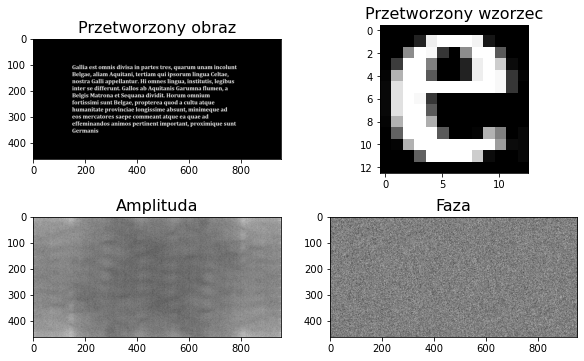

<Figure size 936x576 with 0 Axes>

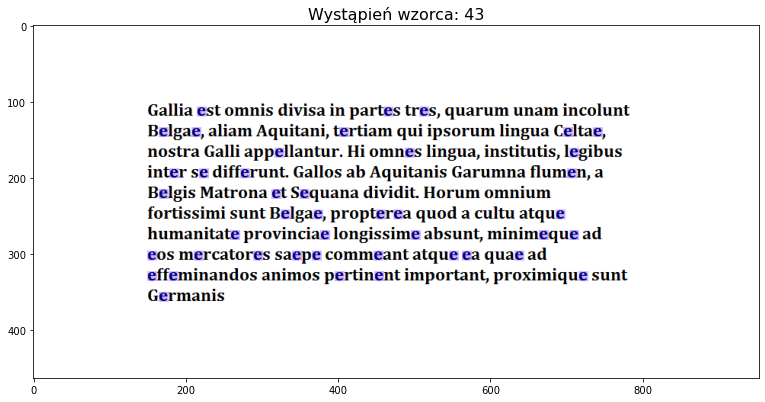

In [166]:
match_pattern_within_image(im_path='img/galia.png', pattern_path='img/galia_e.png', match_color_offset=(-50, -75, 100))

### Test ryby
Uruchamiając algorytm na obrazach ryb liczył się on długo.
Przyjrzałem się bliżej przetworzonym obrazom pośrednim i doszedłem do wniosku, że mają one za mały kontrast.

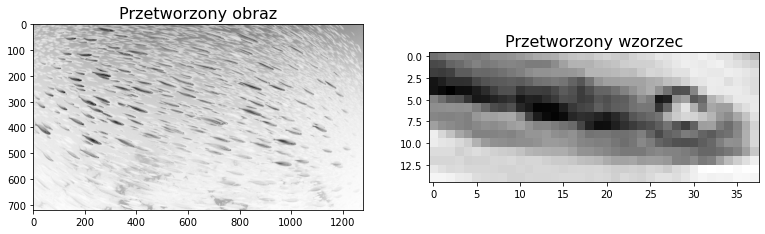

In [167]:
def show_processed(im_processed, pattern_processed, figsize):
    im_processed = unswap(im_processed)
    pattern_processed = unswap(pattern_processed)

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].imshow(im_processed, cmap='gray')
    axs[0].set_title('Przetworzony obraz')
    axs[1].imshow(pattern_processed, cmap='gray')
    axs[1].set_title('Przetworzony wzorzec')
    plt.show()

im, _, _ = open_image('img/fish.jpg')
im_processed = process_image(im)
pattern, _, _ = open_image('img/fish1.png')
pattern_processed = process_image(pattern)
show_processed(im_processed, pattern_processed, (13, 8))

Rozwiązałem problem poprzez dodanie dodatkowego kroku przy przetwarzaniu obrazów.

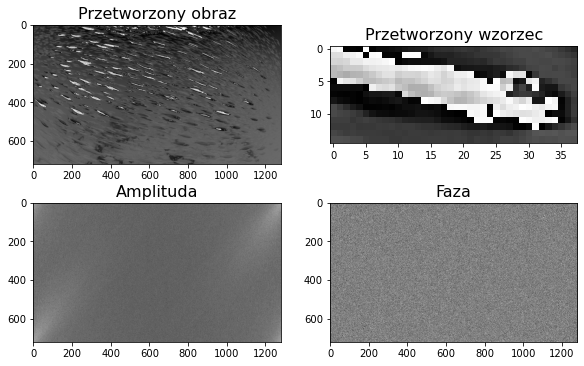

<Figure size 936x576 with 0 Axes>

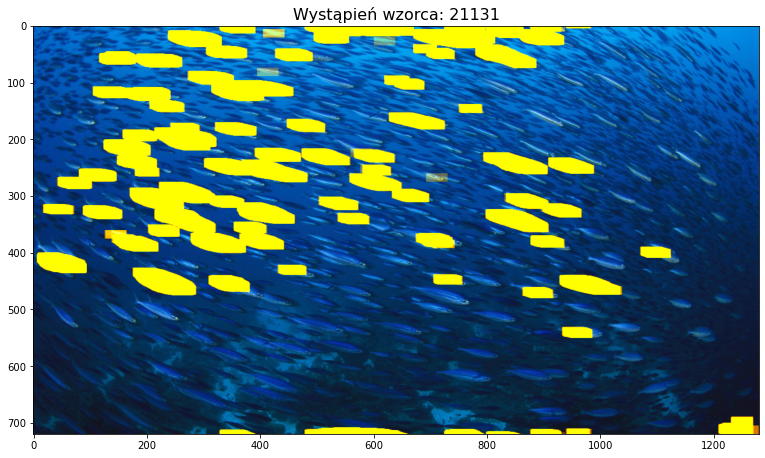

In [168]:
match_pattern_within_image(im_path='img/fish.jpg', pattern_path='img/fish1.png',
                           min_match_perc=0.5, match_color_offset=(100, 50, -50),
                           additional_process_im=lambda im: np.abs(np.array(im) - 130),
                           additional_process_pattern=lambda im: np.abs(np.array(im) - 130))

### Wnioski

Algorytm radzi sobie z pierwszym testem bezbłednie, z drugim gorzej.
Wynika to z faktu, że wzorce występujące na drugim obrazie są pod różnymi kątami, mają różne rozmiary oraz kontrast.

## Zadanie 2 OCR

Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii
6. Tekst może być obrócony (krzywo zeskanowany w całości)
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
8. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanych
obrazów testowych
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
11. Należy dokonać redukcji szumu na obrazie wejściowym

### Funkcja generująca obrazy do testów

In [169]:
def text_to_image(text, font_name, im_size, save_path_base, rot=0, margin=0.0):
    out = Image.new('RGB', im_size, (255, 255, 255))
    font_size = 1
    font = ImageFont.truetype(font_name, font_size)

    d = ImageDraw.Draw(out)

    while np.all(np.array(d.textsize(text, font)) < (1-margin)*np.array(im_size)):
        font_size += 1
        font = ImageFont.truetype(font_name, font_size)

    font_size -= 1
    font = ImageFont.truetype(font_name, font_size)
    W, H = im_size
    w, h = d.textsize(text, font=font)
    d.multiline_text(((W-w)/2,(H-h)/2), text, font=font, fill=(0, 0, 0))

    if out != 0:
        out = out.rotate(rot, expand=True, fillcolor=(255, 255, 255))

    out_path = f'{save_path_base}_{font_size}_{rot}.png' if rot != 0 else f'{save_path_base}_{font_size}.png'
    out.save(out_path)

    return out_path

lorem_ipsum = ''
with open('lorem_ipsum.txt', 'r') as f:
    lorem_ipsum = f.read()

### OCR

In [170]:
ALPHABET = string.ascii_letters + string.digits + '.,?!'

@dataclass
class MatchCandidate:
    char: str
    C: float
    x0: int
    y0: int

def ocr(im_path, font_name, font_size, C_thresh=1e-5, additional_process=None):
    im, W, H = open_image(im_path)
    if additional_process is not None:
        im, W, H = additional_process(im)
    im_processed = process_image(im)
    im_dft = fft2(im_processed)

    font = ImageFont.truetype(font_name, font_size)
    match_candidates = []
    char_to_pattern_dims = dict()

    for char in ALPHABET:
        w, h = font.getsize(char)
        char_to_pattern_dims[char] = (w, h)
        pattern = Image.new('RGB', (w, h), color='white')
        ImageDraw.Draw(pattern).text((0, 0), char, font=font, fill='black')
        pattern_processed = process_image(pattern)

        max_pattern_C = np.max(np.real(ifft2(fft2(pattern_processed) * fft2(np.rot90(pattern_processed, k=2)))))
        C = np.abs(np.real(ifft2(im_dft * fft2(np.rot90(pattern_processed, k=2), s=[W, H]))) / max_pattern_C - 1)

        for x in range(W):
            for y in range(H):
                if C[x][y] < C_thresh:
                    x0, y0 = x - w + 1, y - h + 1
                    match_candidates.append(MatchCandidate(char, C[x][y], x0, y0))

    char_w, char_h = font.getsize('i')
    space_w, _ = font.getsize(' ')

    matches = defaultdict(dict)
    for candidate in match_candidates:
        box_x = candidate.x0 // char_w
        box_y = candidate.y0 // char_h
        if box_y not in matches:
            matches[box_y][box_x] = candidate
        elif box_x not in matches[box_y]:
            matches[box_y][box_x] = candidate
        elif candidate.C < matches[box_y][box_x].C:
            matches[box_y][box_x] = candidate

    for box_y in sorted(matches):
        prev_x = -1
        for box_x in sorted(matches[box_y]):
            match = matches[box_y][box_x]
            curr_x = match.x0

            if prev_x != -1 and curr_x - prev_x >= space_w:
                print(' ', end='')
            print(match.char, end='')

            prev_x = curr_x + char_to_pattern_dims[match.char][0]
        print()

def ocr_call_unwrapper(im_path):
    parts = im_path.split('/')[-1].split('_')
    font_name = parts[0] + '.ttf'
    font_size = int(parts[-1].split('.')[0])
    ocr(im_path, font_name, font_size)

### Testy

a) Krótki tekst, czcionka bezszeryfowa

In [171]:
ocr_call_unwrapper(text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.2)],
                                 'FreeSans.ttf', (400, 50), 'img/FreeSans_short'))

Lorem ipsum dolor sit amet.
Et autem ullam qui repellat exercitationem est magni facere.
Qui uas minus aut conse uatur a natus veniam id tem or


b) Średniej długości tekst, czcionka bezszeryfowa

In [172]:
ocr_call_unwrapper(text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.5)],
                                 'FreeSans.ttf', (500, 160), 'img/FreeSans_medium'))

Lorem ipsum dolor sit amet.
Et autem ullam qui repellat exercitationem est magni facere.
Qui quas minus aut consequatur a natus veniam id tempora labore
a labore voluptates ad alias consectetur ex labore delectus.
Ut dolore iusto sed tenetur modi sed accusamus suscipit quo
reiciendis tempore ut itaque suscipit.
Qui doloribus dolorum et laboriosam beatae 33


c) Długi tekst, czcionka bezszeryfowa

In [173]:
ocr_call_unwrapper(text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*1.0)],
                                 'FreeSans.ttf', (700, 350), 'img/FreeSans_long'))

Lorem ipsum dolor sit amet.
Et autem ullam qui repellat exercitationem est magni facere.
Qui quas minus aut consequatur a natus veniam id tempora labore
a labore voluptates ad alias consectetur exlabore delectus.
Ut dolore iusto sed tenetur modi sed accusamus suscipit quo
reiciendis tempore ut itaque suscipit.
Qui doloribus dolorum et laboriosam beatae 33 nobis architecto
ut possimus omnis et repellat deserunt et nulla voluptas.
Aut ipsa error cum tenetur ratione qui explicabo pariatur ea
doloribus officiis sed natus velit.
In internos molestias ad laboriosam praesentium vel reprehenderit unde.
Aut optio nesciunt ea possimus reprehenderit et exercitationem repellat
est omnis dolorem et voluptatem assumenda.


a) Krótki tekst, czcionka szeryfowa

In [174]:
ocr_call_unwrapper(text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.2)],
                                 'FreeSerif.ttf', (400, 50), 'img/FreeSerif_short'))

Loremi sumdolor sit amet.
Et autemullamquirepel at exerci ationemest a nifacere.
ui uas nus aut conse uatur a natus ven am d tem or


b) Średniej długości tekst, czcionka szeryfowa

In [175]:
ocr_call_unwrapper(text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.5)],
                                 'FreeSerif.ttf', (500, 160), 'img/FreeSerif_medium'))

Lorem ips m dolor sit met.
Etaut m ll m q i repellatexerci aionem stmag i fa ere.
Q i q s min s autco s q at r a at s ve i m idt mporalabore
alaborevolup at s ad li s co s ct t r ex laboredel ct s.
Utdolorei sto s dt net r mo i s da c s m s s scipitquo
reicien is t mporeuti aques scipit.
i dolorib s dolor m etlaborios m b aa 33


c) Długi tekst, czcionka szeryfowa

In [176]:
ocr_call_unwrapper(text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*1.0)],
                                 'FreeSerif.ttf', (700, 350), 'img/FreeSerif_long'))

orem ipsum dolor sitamet.
Etautem ullam qui repellatexerci ationem estma ni facere.
Qui quas minus autconsequatur a natus veniam id tempora labore
a labore volup ates ad alias consectetur ex labore delectus.
Utdolore iusto sed tenetur modi sed accusamus suscipitquo
reiciendis tempore uti aque suscipit.
Qui doloribus dolorum etlaboriosam bea ae 33 nobis architecto
utpossimus omnis etrepellatdeseruntetnulla volup as.
Autipsa error cum tenetur ratione qui explicabo pariatur ea
doloribus officiis sed natus velit.
In internos molestias ad laboriosam praesentium vel reprehenderitunde.
Autoptio nesciuntea possimus reprehenderitetexerci ationem repellat
estomnis dolorem etvolup atem assumenda.


### Wnioski
Algorytm lepiej sobie radzi z czcionką bezszeryfową.
Długość tekstu ani rozmiar nie mają większego wpływu na wynik.

### Próba uwzględnienia rotacji obrazu
Połączenie funkcji `rotate_image` oraz `crop_text` zwraca obrócony obraz do domyślnego kąta, przycięty tak
aby pierwszy znak tekstu znajdował się w lewym, górnym rogu.
Algorytm nie zwraca sensownych wyników dla przetworzonych w ten sposób obrazów.

In [177]:
import cv2

def rotate_image(im):
    im_arr = np.asarray(im)
    im_gray = cv2.cvtColor(im_arr, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.bitwise_not(im_gray)

    thresh = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    coords = np.column_stack(np.where(thresh > 0))
    rot = cv2.minAreaRect(coords)[-1]

    out = Image.fromarray(np.uint8(im))
    out = out.rotate(-rot, expand=True, fillcolor=(255, 255, 255))
    w, h = out.size

    return out, w, h

# https://stackoverflow.com/questions/72202507/how-to-crop-image-to-only-text-section-with-python-opencv
def crop_text(im):
    im_arr = np.asarray(im)
    # Read in the image and convert to grayscale
    im_arr = im_arr[:-20, :-20]  # Perform pre-cropping
    gray = cv2.cvtColor(im_arr, cv2.COLOR_BGR2GRAY)
    gray = 255*(gray < 180).astype(np.uint8)  # To invert the text to white
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones(
        (2, 2), dtype=np.uint8))  # Perform noise filtering
    coords = cv2.findNonZero(gray)  # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords)  # Find minimum spanning bounding box
    # Crop the image - note we do this on the original image
    rect = im_arr[y-2:y+h+1, x-2:x+w+1]
    out = Image.fromarray(np.uint8(rect))
    w, h = out.size
    return out, w, h

def rot_additional_process(im):
    show_image(im, (13, 8), 'Przed przetworzeniem')
    im, _, _ = rotate_image(im)
    show_image(im, (13, 8), 'Po rotacji')
    im, W, H = crop_text(im)
    show_image(im, (13, 8), 'Po przycięciu')
    return im, W, H

def rot_ocr_call_unwrapper(im_path):
    parts = im_path.split('/')[-1].split('_')
    font_name = parts[0] + '.ttf'
    font_size = int(parts[2])
    ocr(im_path, font_name, font_size, additional_process=rot_additional_process)

<Figure size 936x576 with 0 Axes>

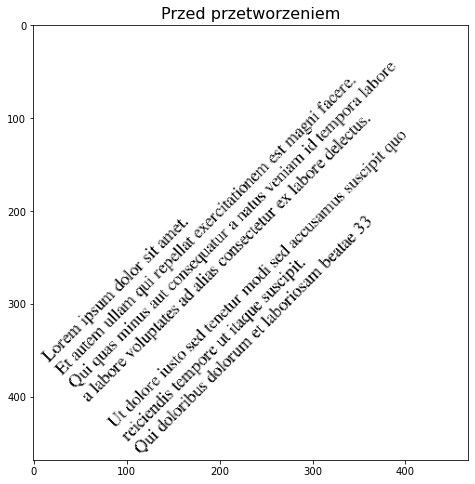

<Figure size 936x576 with 0 Axes>

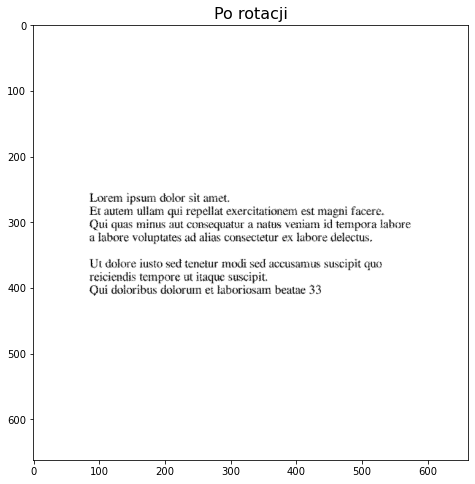

<Figure size 936x576 with 0 Axes>

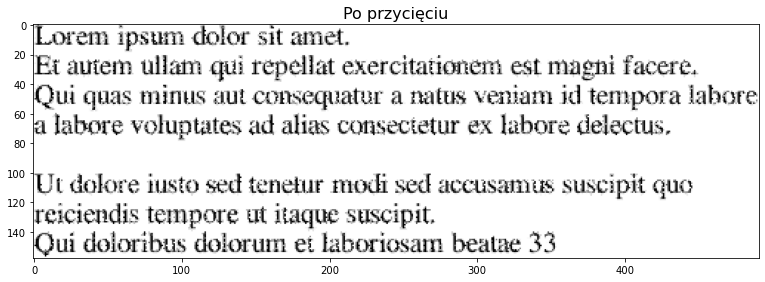

.
.


In [178]:
rot_ocr_call_unwrapper(text_to_image(lorem_ipsum[:int(len(lorem_ipsum)*0.5)],
                                     'FreeSerif.ttf', (500, 160), 'img/FreeSerif_medium', rot=45))